# Hollywood as a voice of the time

## <span style="color:red">MISSING EVERYTHING</span>


In [15]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import json
import json
from collections import Counter, defaultdict
from datetime import datetime
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from helpers import create_df_G_from_path, look_up_decade, process_data
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os
import sys
from PIL import Image
sys.path.append("../") # go to parent dir


#Init stopwords
stop_words = set(stopwords.words('english'))

In [2]:
# Init graph and df
df,G = create_df_G_from_path('../')

In [3]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf=Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized



In [4]:
# Extracting the data
docs=load_segmented_documents(df,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)

/Users/admin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/admin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [9]:
# Get wiki data
wiki_data = {}
for year in tfidf.keys():
    wiki_data[year]=tokenize(process_data(look_up_decade(year)))
# All words 
collection = wiki_data.values()

# TF-IDF wiki
tfidf_wiki = {}
for year, text in wiki_data.items():
    tfidf_wiki[year]=calculate_tf_idf(text, collection)

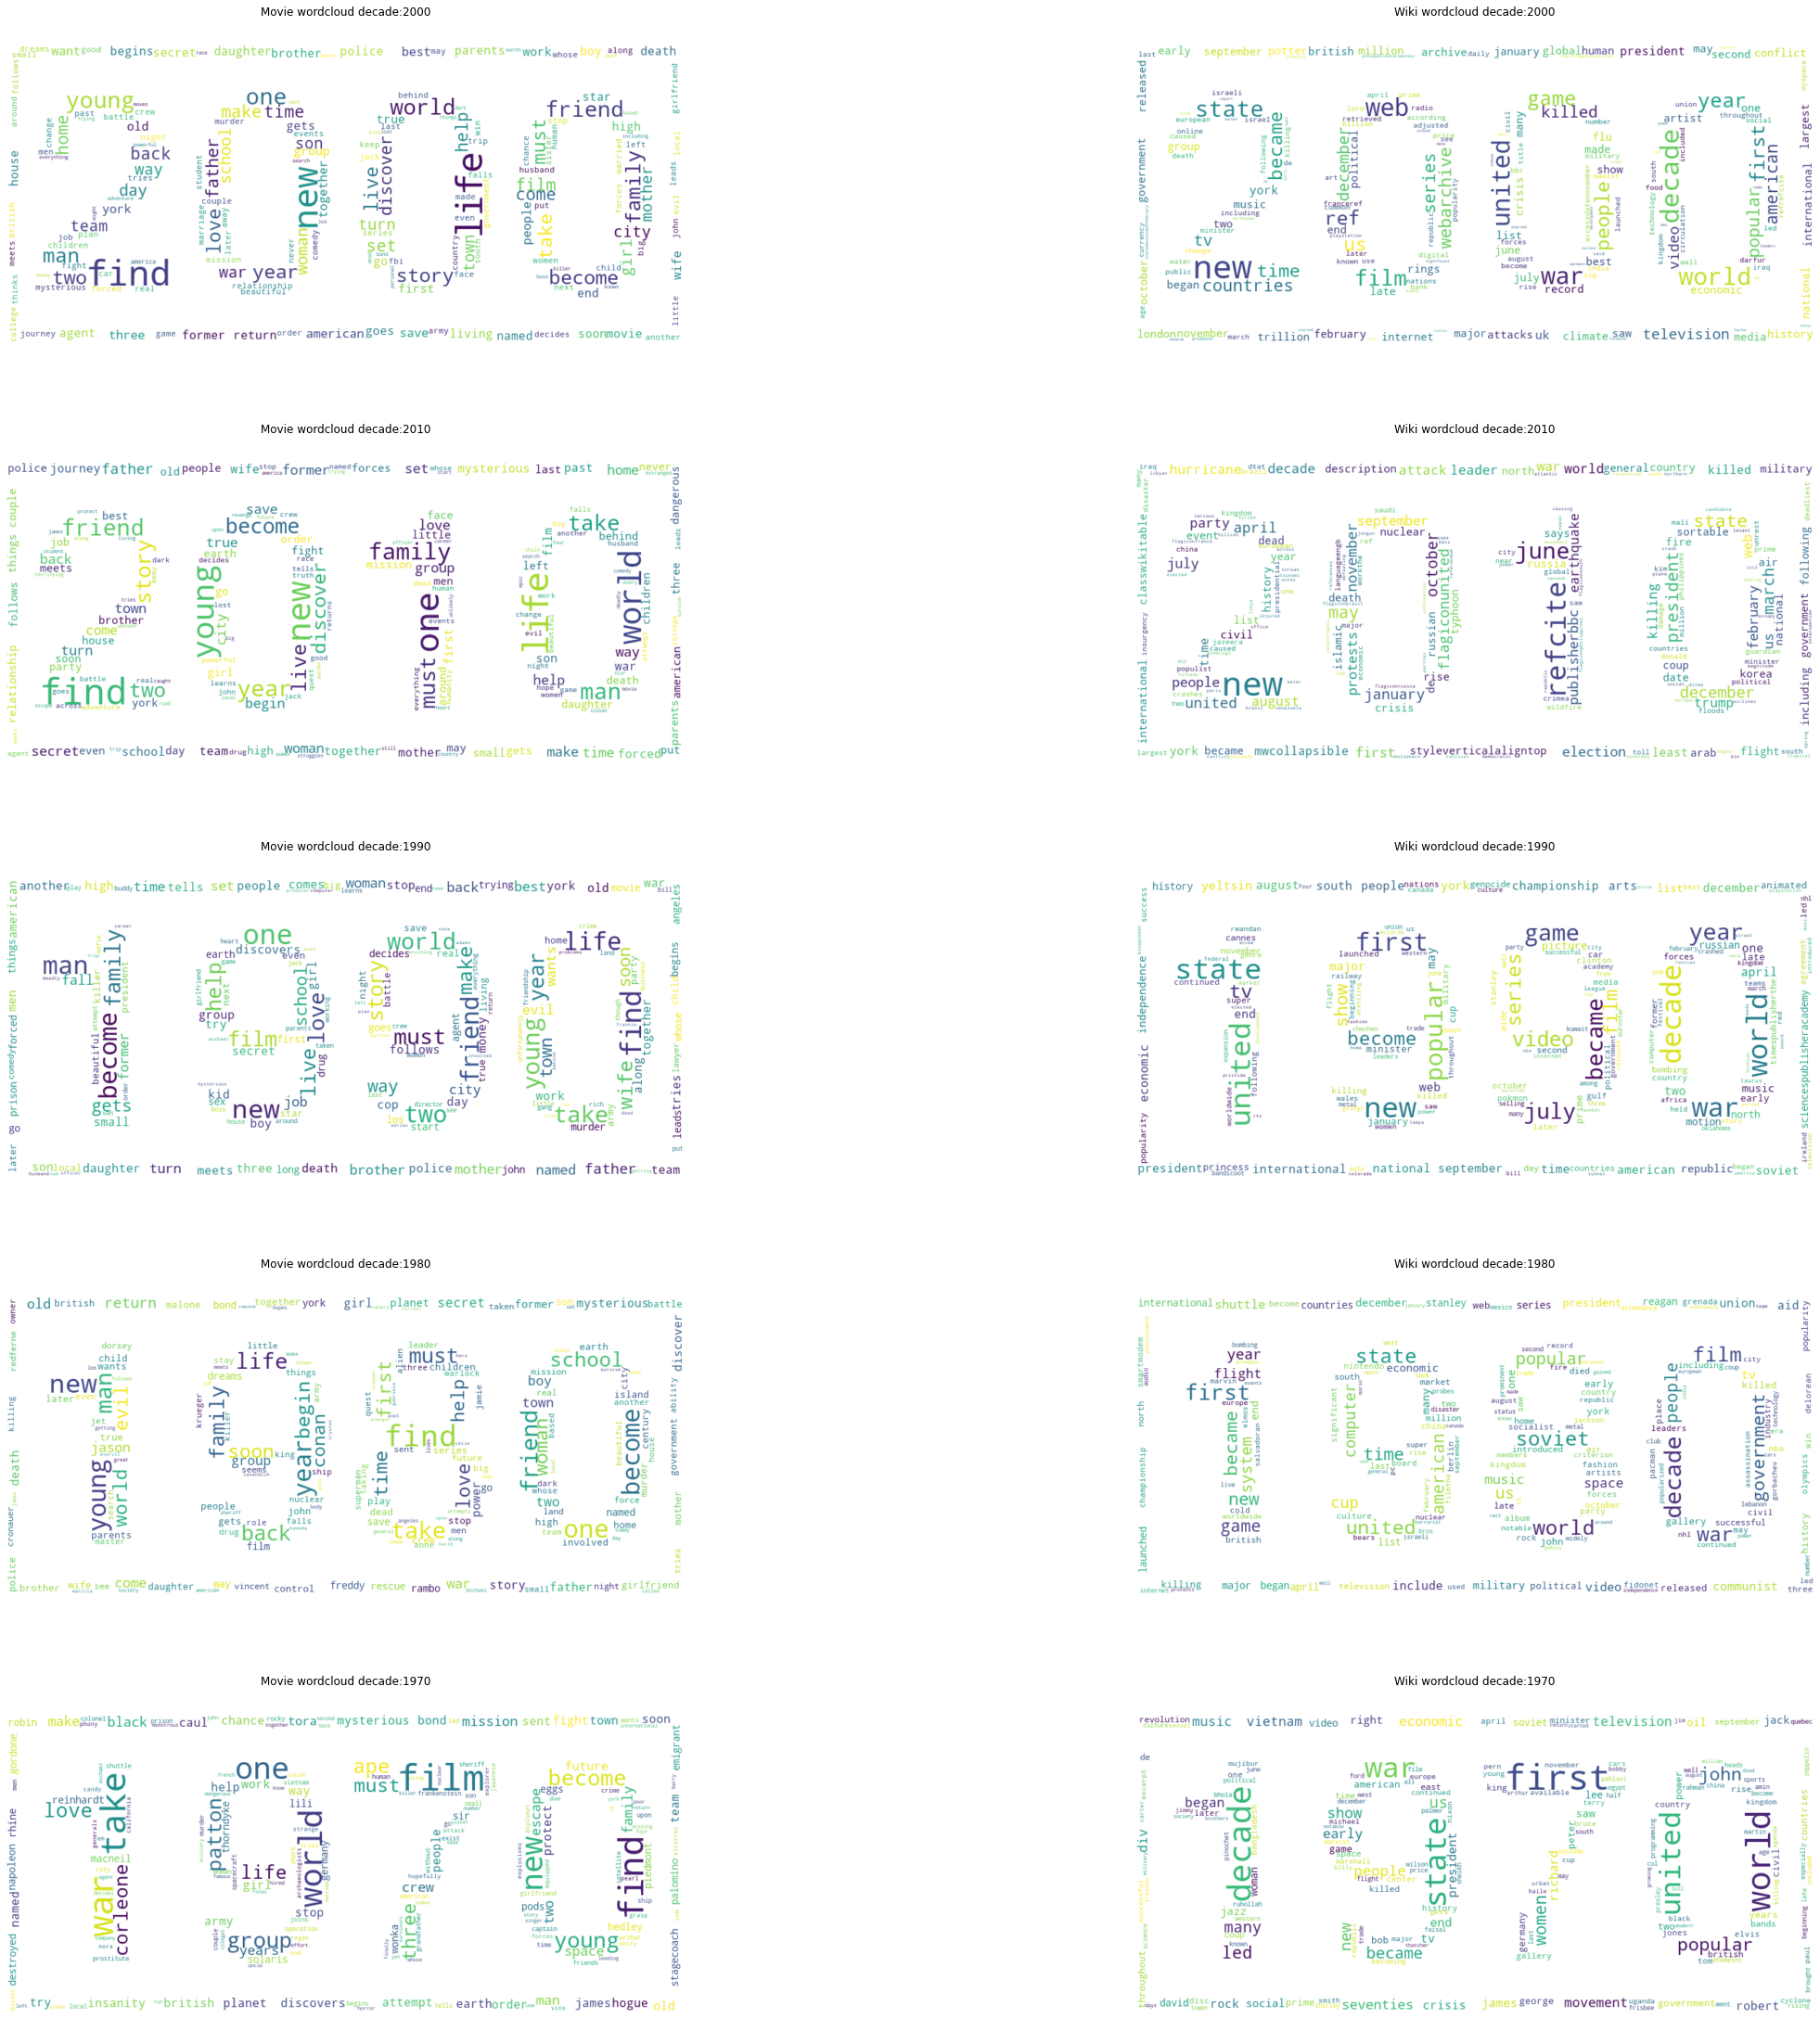

In [18]:
nr=len(tfidf)
nc=2
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(40,40))
idx=0
year_keys = [x for x in tfidf.keys()]
top_x_words = 200

for i in range(nr):
    year = year_keys[idx]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir('../')]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'../{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][0].imshow(wc, interpolation="bilinear")
    ax[i][0].set_title(f'Movie wordcloud decade:{year}')
    ax[i][0].axis("off")
    
    # Wiki
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf_wiki[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][1].imshow(wc, interpolation="bilinear")
    ax[i][1].set_title(f'Wiki wordcloud decade:{year}')
    ax[i][1].axis("off")

    idx+=1
plt.show()